#Importing data

The data was imported one-by-one by month from here:
https://database.lichess.org/
Last month is currently 

In [ ]:
import chess.pgn
import pandas as pd
import bz2
import matplotlib.pyplot as plt
import numpy as np
import math

#%cd Chess_project

fi = "2023-02.pgn"
fi_date = fi[:7]
with open(fi, "r") as file:
    data = file.read()

data = str(data) # Convert binary data into string for easier functionality
raw_games = data.split('[Event') # Split the data into chess games using the '[Event' string
print("Game at 0th index: %s" % raw_games[0])
del raw_games[0] # The first index isn't a game
del data # Remove binary string to save memory

ModuleNotFoundError: ignored

In [ ]:
analysis_games = 0
empty_games = 0

print("Sample normal game: %s\n" % raw_games[0])
for game in raw_games:
    if game.find('eval') != -1:
        if analysis_games == 0:
            print("Sample game with analysis attached: %s\n" % game)
        analysis_games += 1

for game in raw_games:
    if game.find('1.') == -1:
        if empty_games == 0:
            print("Sample empty game: %s" % game)
        empty_games += 1

NameError: ignored

In [ ]:
all_games = []
for i in range(len(raw_games)):
    if raw_games[i].find('eval') != -1 or raw_games[i].find('1.') == -1 or 'l "-"' in raw_games[i]: #last one deals with correspondence games
        continue
    else:
        all_games.append(raw_games[i])

del raw_games # remove old uncleaned version to save memory

In [ ]:
len(all_games)

In [ ]:
%%time
mode_list = []
for game in all_games:
    
    # Time Control
    index = game.find('TimeControl') + 13
    s = ""
    while True:
        if game[index] == '"':
            break
        s += game[index]
        index += 1
    mode_list.append(s)


In [ ]:
#Convert time control into seconds using 2*(starting_time+increment*40)
seconds_list = [2*(int(x.split("+")[0])) + (int(x.split("+")[1])*40) for x in mode_list]

In [ ]:
avg = str(int(np.average(seconds_list)))

In [ ]:
with open("the_list.txt", "r+") as f:
    data = f.read()
    f.seek(0)
    f.write(data + '\n"' + fi_date + '",' + avg)
    f.truncate()

Note: I changed 2020-08 to 470 (avg of 07 and 09) because of summer marathon
https://lichess.org/tournament/summer20

#Analizing data

In [ ]:
#%cd
#%cd Chess_project

import pandas as pd
from pandas import DataFrame
from pandas import Grouper
from pandas.plotting import autocorrelation_plot
import bz2
import matplotlib.pyplot as plt
import numpy as np
import math
from math import sqrt
import seaborn as sns
from scipy.stats import boxcox
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.multioutput import RegressorChain
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
import warnings
import statsmodels.api as sm

series = pd.read_csv("the_list.csv", header=0, index_col=0, parse_dates=True, squeeze=True)

## Chapter 1.

###Descriptive statistics

In [ ]:
print(series.describe())

count    122.000000
mean     575.975410
std       94.744586
min      453.000000
25%      489.750000
50%      563.500000
75%      661.750000
max      774.000000
Name: Seconds, dtype: float64


###KDE plot

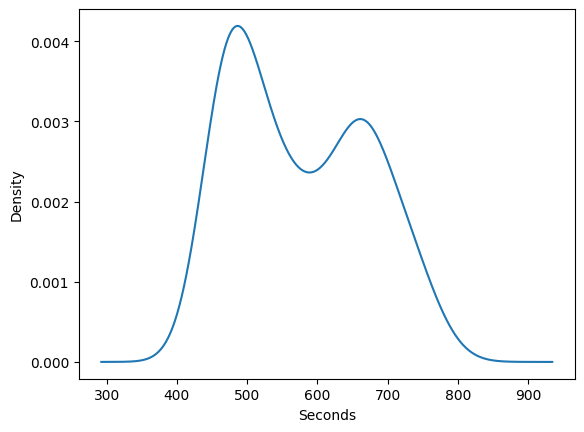

In [ ]:
series.plot(kind='kde')
plt.xlabel('Seconds')
plt.show()

###Histogram

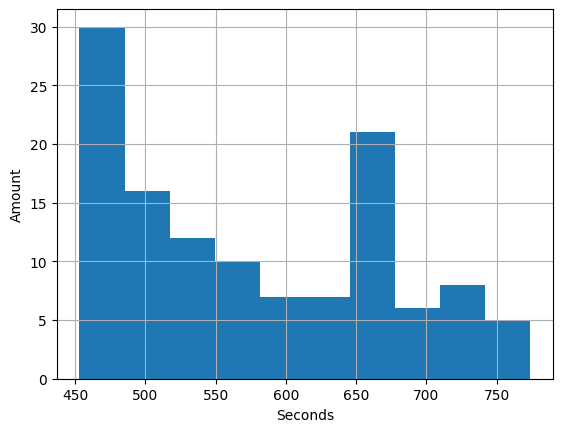

In [ ]:
series.hist()
plt.ylabel('Amount')
plt.xlabel('Seconds')
plt.show()

###Line plot

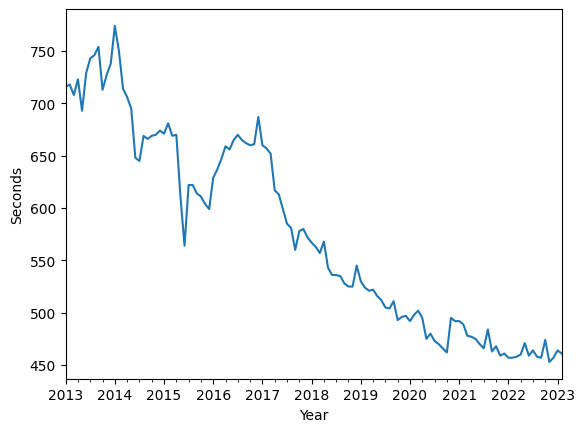

In [ ]:
series.plot()

plt.xlabel('Year')
plt.ylabel('Seconds')

plt.show()

###Boxplot

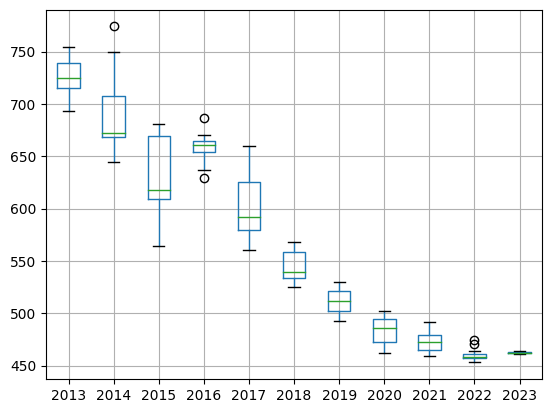

In [ ]:
groups = series.groupby(Grouper(freq='A'))
years = DataFrame()
for name, group in groups:
  values = group.values
  if len(values) < 12:
    values = np.append(values, [np.nan] * (12 - len(values)))
  years[name.year] = values
years.boxplot()
plt.show()

###Heatmap

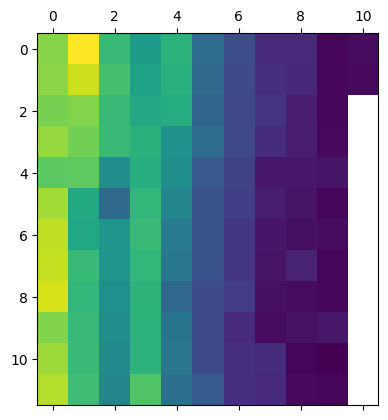

In [ ]:
groups = series.groupby(Grouper(freq='A'))
years = DataFrame()
for name, group in groups:
  values = group.values
  if len(values) < 12:
    values = np.append(values, [np.nan] * (12 - len(values)))
  years[name.year] = values
plt.matshow(years, interpolation=None, aspect='auto')
plt.show()

###Rolling mean/min/max for a year

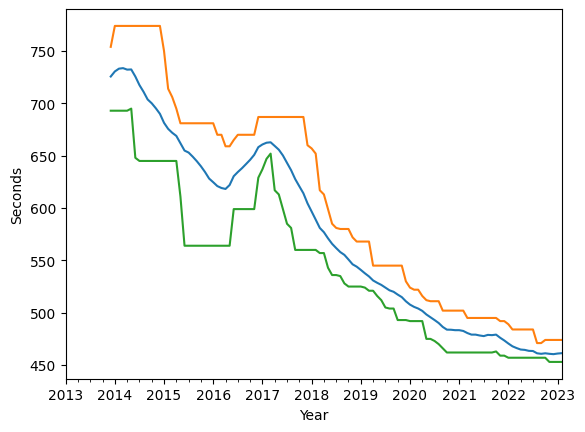

In [ ]:
series.rolling(window=12).mean().plot()
series.rolling(window=12).max().plot()
series.rolling(window=12).min().plot()
plt.xlabel('Year')
plt.ylabel('Seconds')
plt.show()

###Diff function

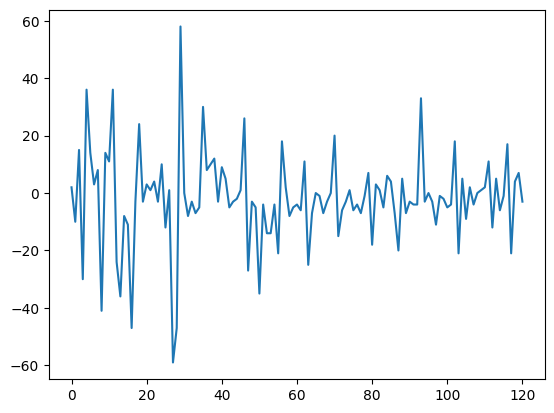

In [ ]:
diffs = pd.Series(np.diff(series))
diffs.plot()
plt.show()

## Chapter 2.

###Square root transformation

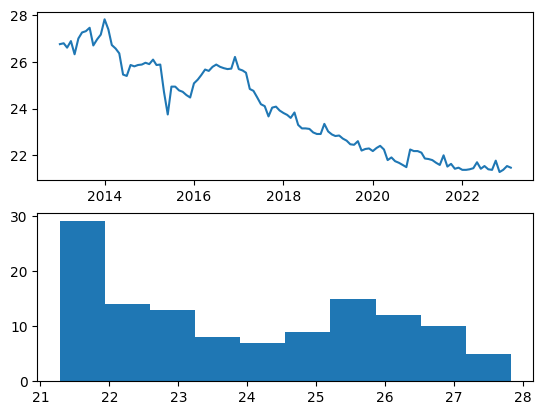

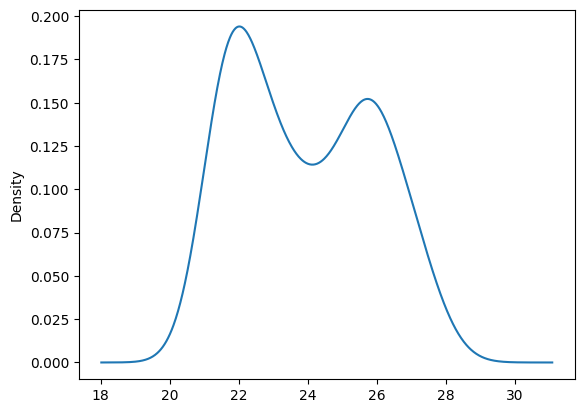

In [ ]:
#sqrt transform
transform = np.sqrt(series)
plt.figure(1)
#line plot
plt.subplot(211)
plt.plot(transform)
#histogram
plt.subplot(212)
plt.hist(transform)
plt.show()
#kde plot
transform.plot(kind='kde')
plt.show()

###Log transformation

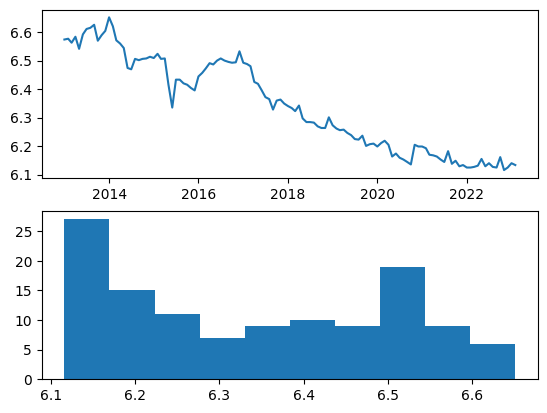

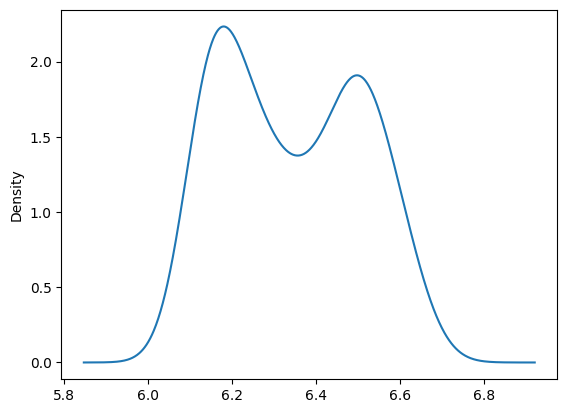

In [ ]:
transform = np.log(series)
plt.figure(1)
#line plot
plt.subplot(211)
plt.plot(transform)
#histogram
plt.subplot(212)
plt.hist(transform)
plt.show()
#kde plot
transform.plot(kind='kde')
plt.show()

###Box-Cox transformation

Lambda: -0.678620


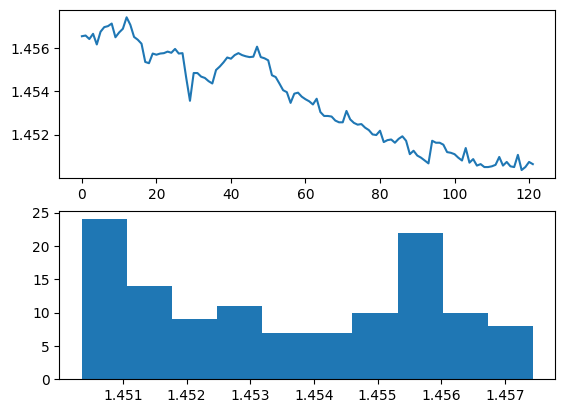

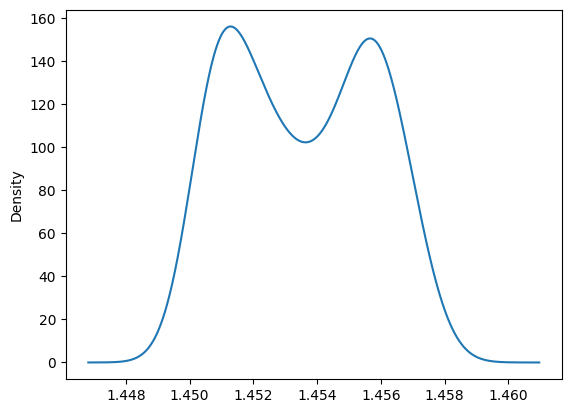

In [ ]:
transform, lam = boxcox(series)
transform = pd.Series(transform)
print('Lambda: %f' % lam)
plt.figure(1)
# vonal ábra
plt.subplot(211)
plt.plot(transform)
# histogram
plt.subplot(212)
plt.hist(transform)
plt.show()
# displot
transform.plot(kind='kde')
plt.show()

### Moving average

In [ ]:
df = DataFrame(series.values)
width = 3
lag1 = df.shift(1)
lag3 = df.shift(width - 1)
window = lag3.rolling(window=width)
means = window.mean()
dataframe = pd.concat([means, lag1, df], axis=1)
dataframe.columns = ['mean', 't', 't+1']
print(dataframe.head(10))

         mean      t  t+1
0         NaN    NaN  716
1         NaN  716.0  718
2         NaN  718.0  708
3         NaN  708.0  723
4  714.000000  723.0  693
5  716.333333  693.0  729
6  708.000000  729.0  743
7  715.000000  743.0  746
8  721.666667  746.0  754
9  739.333333  754.0  713


<Axes: >

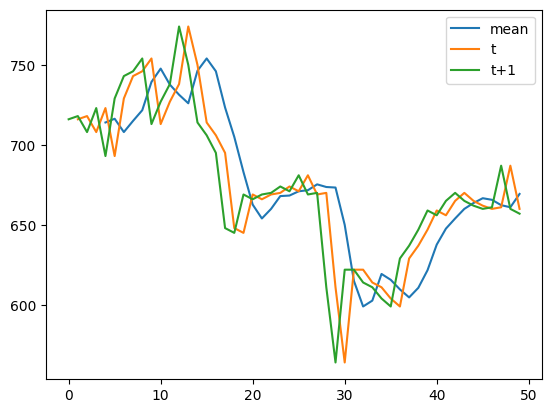

In [ ]:
dataframe.head(50).plot()

In [ ]:
#Predicting with moving average
X = series.values
window = 3
history = [X[i] for i in range(window)]
test = [X[i] for i in range(window, len(X))]
predictions = list()
for t in range(len(test)):
  length = len(history) 
  yhat = np.mean([history[i] for i in range(length-window,length)])
  obs = test[t]
  predictions.append(yhat)
  history.append(obs)
  print('predicted=%f, expected=%f' % (yhat, obs))


predicted=714.000000, expected=723.000000
predicted=716.333333, expected=693.000000
predicted=708.000000, expected=729.000000
predicted=715.000000, expected=743.000000
predicted=721.666667, expected=746.000000
predicted=739.333333, expected=754.000000
predicted=747.666667, expected=713.000000
predicted=737.666667, expected=727.000000
predicted=731.333333, expected=738.000000
predicted=726.000000, expected=774.000000
predicted=746.333333, expected=750.000000
predicted=754.000000, expected=714.000000
predicted=746.000000, expected=706.000000
predicted=723.333333, expected=695.000000
predicted=705.000000, expected=648.000000
predicted=683.000000, expected=645.000000
predicted=662.666667, expected=669.000000
predicted=654.000000, expected=666.000000
predicted=660.000000, expected=669.000000
predicted=668.000000, expected=670.000000
predicted=668.333333, expected=674.000000
predicted=671.000000, expected=671.000000
predicted=671.666667, expected=681.000000
predicted=675.333333, expected=669

RMSE: 19.005


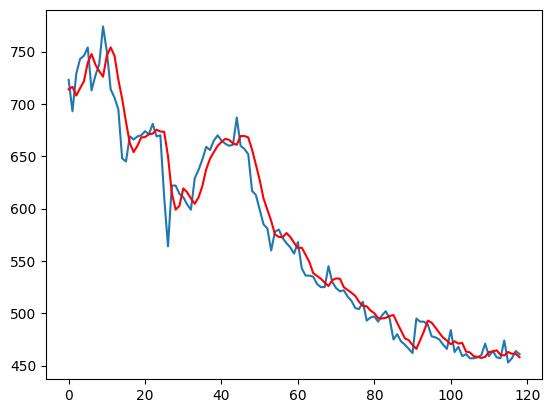

In [ ]:
#evaluating error
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)
#plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

### Is the time series a white noise or a random walk?

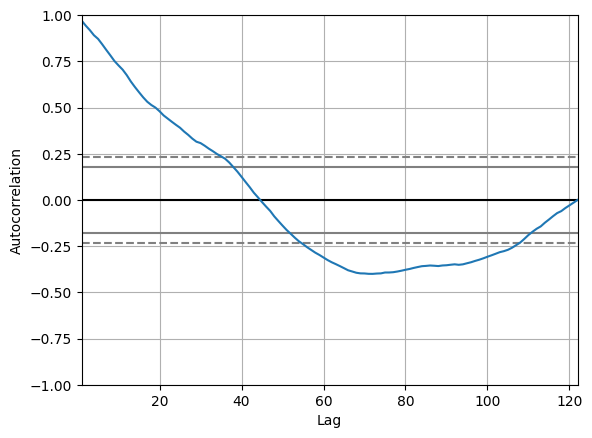

In [ ]:
pd.plotting.autocorrelation_plot(series)
plt.show()

In [ ]:
#ADF test
result = adfuller(series)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
  print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.128185
p-value: 0.703702
Critical Values:
	1%: -3.486
	5%: -2.886
	10%: -2.580


##Chapter 3.

###Additive decomposition

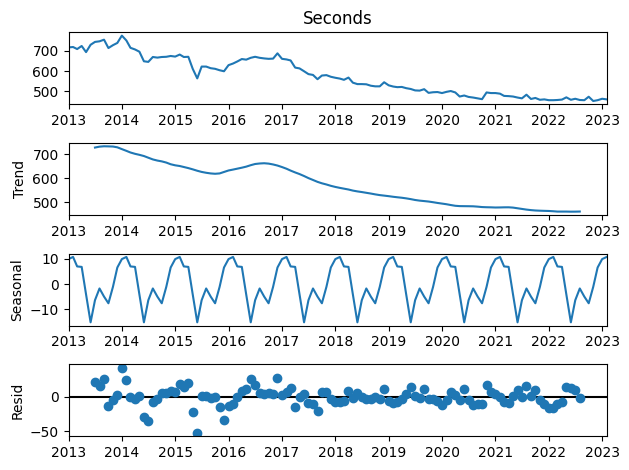

In [ ]:
result = seasonal_decompose(series, model='additive')
result.plot()
plt.show()

###Multiplicative decomposition

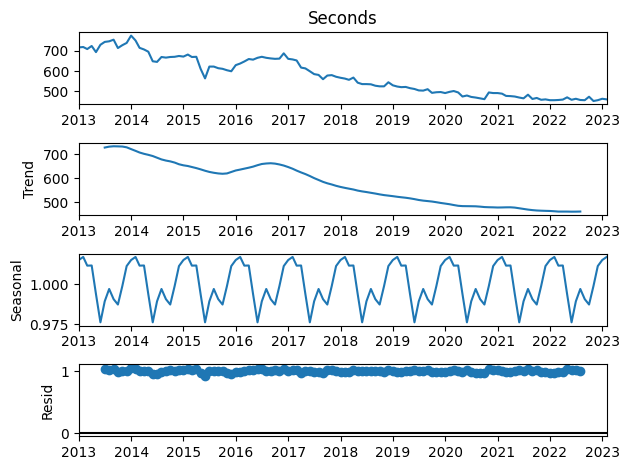

In [ ]:
result = seasonal_decompose(series, model='multiplicative')
result.plot()
plt.show()

###Detrending with difference

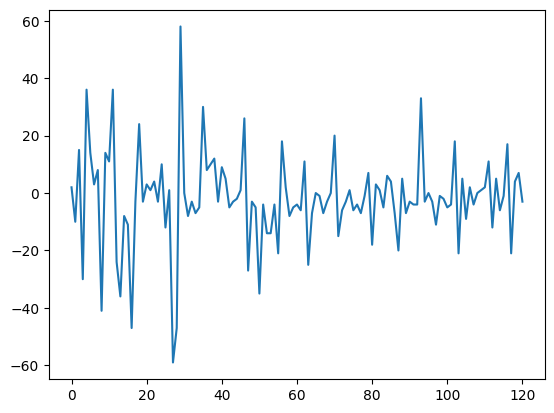

In [ ]:
X = series.values
diff = list()
for i in range(1, len(X)):
  value = X[i] - X[i - 1]
  diff.append(value)
plt.plot(diff)
plt.show()

### Detrending with model fitting

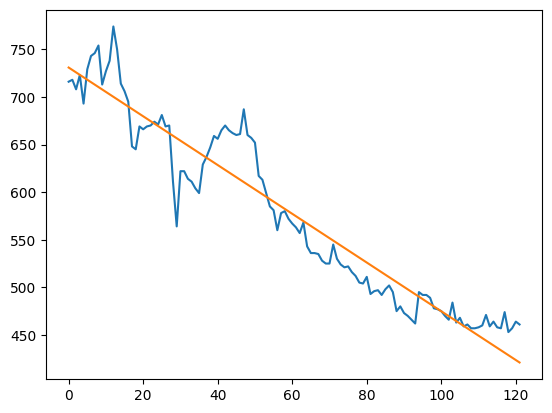

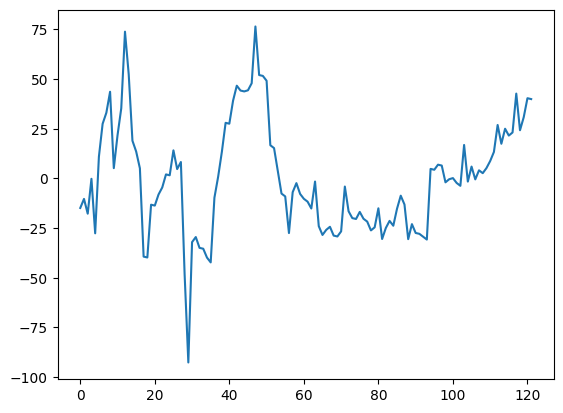

In [ ]:
X = [i for i in range(0, len(series))]
X = np.reshape(X, (len(X), 1))
y = series.values
model = LinearRegression()
model.fit(X, y)

trend = model.predict(X)


plt.plot(y)
plt.plot(trend)
plt.show()

detrended = [y[i]-trend[i] for i in range(0, len(series))]

plt.plot(detrended)
plt.show()

###Removing seasonality with difference

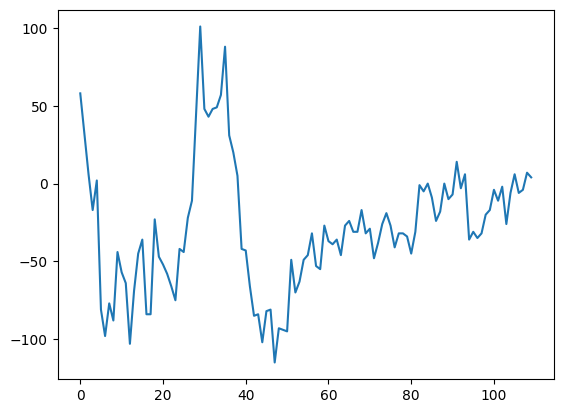

In [ ]:
X = series.values
diff = list()
months_in_year = 12
for i in range(months_in_year, len(X)):
  value = X[i] - X[i - months_in_year]
  diff.append(value)
plt.plot(diff)
plt.show()

###Removing seasonality with model fitting

In [ ]:
X = [i%12 for i in range(0, len(series))]
y = series.values
degree = 4
coef = np.polyfit(X, y, degree)
print('Coefficients: %s' % coef)

Coefficients: [-1.56804060e-02  4.28021218e-01 -3.52148197e+00  6.45941431e+00
  5.85611609e+02]


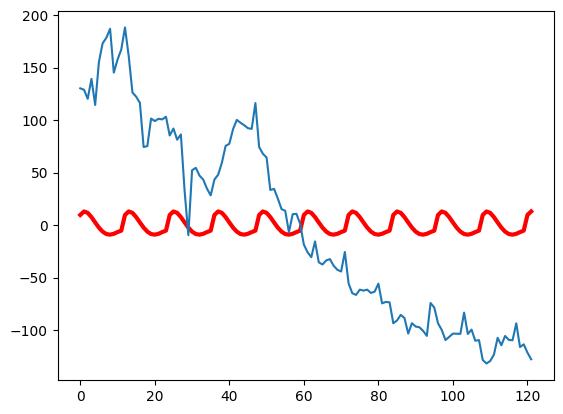

In [ ]:
curve = list()
curve2 = list()
for i in range(len(X)):
  value = coef[-1]
  for d in range(degree):
    value += X[i]**(degree-d) * coef[d]
  curve.append(value)
  curve2.append(value-575.975)

values = series.values
diff = list()
for i in range(len(values)):
  value = values[i] - curve[i]
  diff.append(value)

plt.plot(curve2, color='red', linewidth=3)
plt.plot(diff)
plt.show()

##Chapter 4.

###Checking stationarity

In [ ]:
X = series.values
split = int(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=659.754098, mean2=492.196721
variance1=2815.660844, variance2=952.518678


###Walk forward prediction

In [ ]:
def walk_forward(step,window,series):
  X = series.iloc[step:step+window]
  y = series.iloc[step+window]
  return X,y

In [ ]:
window = 12
y_old = []
y_new = []
y_newMA = []
for step in range(0, len(series)-window):
  X,y = walk_forward(step,window,series)
  y_pred = X[-1]
  y_new.append(y_pred)
  y_pred = X.rolling(window=5).mean()[-1]
  y_newMA.append(y_pred)
  y_old.append(y)

MAE = mean_absolute_error(y_newMA, y_old)
print(f'MAE: {MAE}')
mse = mean_squared_error(y_newMA, y_old)
print(f'MSE: {mse}')
rmse = sqrt(mse)
print(f'RMSE: {rmse}')

MAE: 15.067272727272728
MSE: 478.3574545454544
RMSE: 21.871384376519345


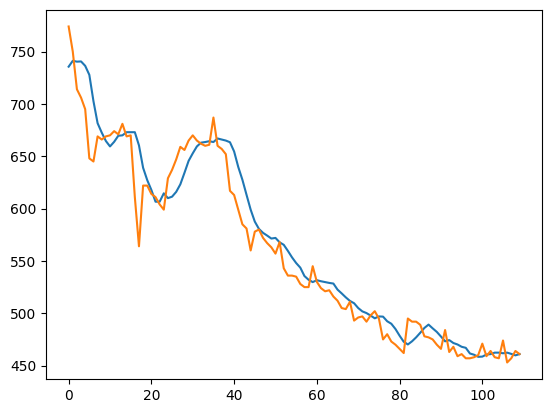

In [ ]:
predicted = []
old_value = []
for step in range(0, len(series)-window):
  X,y = walk_forward(step,window,series)
  y_pred = X.rolling(window=5).mean()[-1]
  predicted.append(y_pred)
  old_value.append(y)

plt.plot(predicted, label='forecast')
plt.plot(old_value, label='real')
plt.show()

###Autocorrelation plot for walk forward

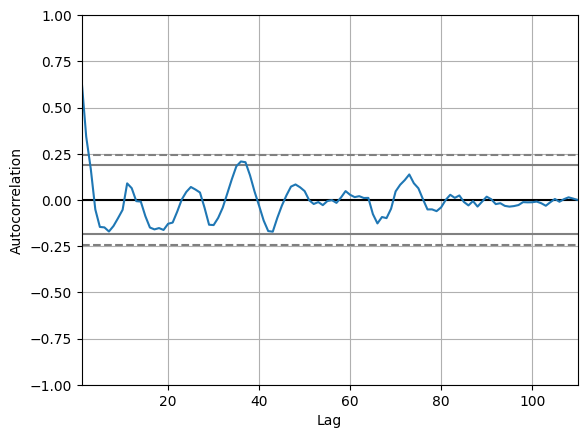

In [ ]:
residuals = [y_old[i]-y_newMA[i] for i in range(len(y_newMA))]
residuals = pd.DataFrame(residuals)
autocorrelation_plot(residuals)
plt.show()

###Expanding window prediction

In [ ]:
def expanding_window(step,window,series):
  X = series.iloc[:step+window]
  y = series.iloc[step+window]
  return X,y

In [ ]:
error = []
window = 12
y_old = []
y_new = []
for step in range(0, len(series)-window):
  X,y = expanding_window(step,window,series)
  X,y = walk_forward(step,window,series)
  y_pred = X[-1]
  y_old.append(y)
  y_new.append(y_pred)

MAE = mean_absolute_error(y_new, y_old)
print(f'MAE: {MAE}')
mse = mean_squared_error(y_new, y_old)
print(f'MSE: {mse}')
rmse = sqrt(mse)
print(f'RMSE: {rmse}')

MAE: 10.172727272727272
MSE: 244.9909090909091
RMSE: 15.65218544136598


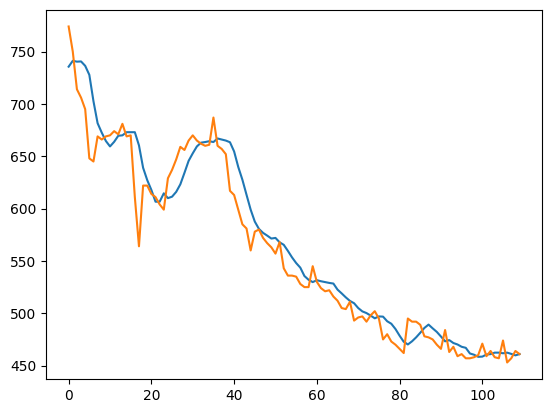

In [ ]:
predicted = []
old_value = []
for step in range(0, len(series)-window):
  X,y = expanding_window(step,window,series)
  y_pred = X.rolling(window=5).mean()[-1]
  predicted.append(y_pred)
  old_value.append(y)

plt.plot(predicted, label='forecast')
plt.plot(old_value, label='real')
plt.show()

### Autocorrelation plot for expanding windows

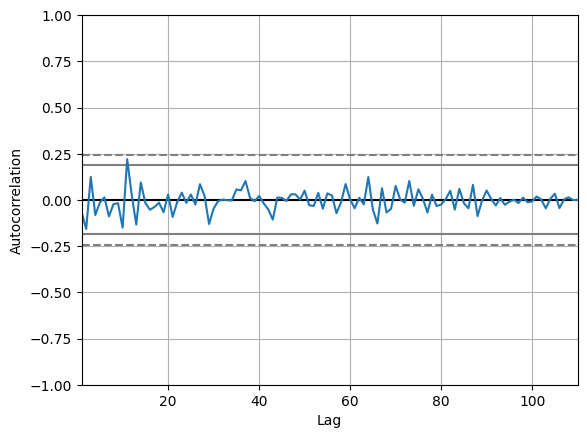

In [ ]:
residuals = [y_old[i]-y_new[i] for i in range(len(y_new))]
residuals = pd.DataFrame(residuals)
autocorrelation_plot(residuals)
plt.show()

##Chapter 5.

###Arima model

In [ ]:
def evaluate_arima_model(X, arima_order):

  train_size = int(len(X) * 0.66)
  train, test = X[0:train_size], X[train_size:]
  history = [x for x in train]

  predictions = list()
  for t in range(len(test)):
    model = ARIMA(history, order=arima_order)
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    history.append(test[t])

  rmse = sqrt(mean_squared_error(test, predictions))
  return rmse

In [ ]:
def evaluate_models(dataset, p_values, d_values, q_values):
  dataset = dataset.astype('float32')
  best_score, best_cfg = float("inf"), None
  for p in p_values:
    for d in d_values:
      for q in q_values:
        order = (p,d,q)
        rmse = evaluate_arima_model(dataset, order)
        try:
          rmse = evaluate_arima_model(dataset, order)
          if rmse < best_score:
            best_score, best_cfg = rmse, order
          print('ARIMA%s RMSE=%.3f' % (order,rmse))
        except:
          continue
  print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [ ]:
p_values = [1, 2, 4]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

ARIMA(1, 0, 0) RMSE=10.530
ARIMA(1, 0, 1) RMSE=10.345
ARIMA(1, 0, 2) RMSE=10.406
ARIMA(1, 1, 0) RMSE=9.971
ARIMA(1, 1, 1) RMSE=9.905
ARIMA(1, 1, 2) RMSE=9.733
ARIMA(1, 2, 0) RMSE=13.177
ARIMA(1, 2, 1) RMSE=10.030
ARIMA(1, 2, 2) RMSE=10.351
ARIMA(2, 0, 0) RMSE=10.365
ARIMA(2, 0, 1) RMSE=10.734
ARIMA(2, 0, 2) RMSE=10.116
ARIMA(2, 1, 0) RMSE=10.025
ARIMA(2, 1, 1) RMSE=9.714
ARIMA(2, 1, 2) RMSE=9.880
ARIMA(2, 2, 0) RMSE=11.952
ARIMA(2, 2, 1) RMSE=10.086
ARIMA(2, 2, 2) RMSE=9.766
ARIMA(4, 0, 0) RMSE=10.403
ARIMA(4, 0, 1) RMSE=10.127
ARIMA(4, 0, 2) RMSE=10.830
ARIMA(4, 1, 0) RMSE=9.967
ARIMA(4, 1, 1) RMSE=9.678
ARIMA(4, 1, 2) RMSE=9.680
ARIMA(4, 2, 0) RMSE=11.136
ARIMA(4, 2, 1) RMSE=10.005
ARIMA(4, 2, 2) RMSE=9.724
Best ARIMA(4, 1, 1) RMSE=9.678


###Visualizing best parameters

In [ ]:
train_size = int(len(series) * 0.66)
train, test = series[0:train_size], series[train_size:]
history = [x for x in train]

predictions = list()
for t in range(len(test)):
  model = ARIMA(history, order=(4,1,1))
  model_fit = model.fit()
  yhat = model_fit.forecast()[0]
  predictions.append(yhat)    
  history.append(test[t])

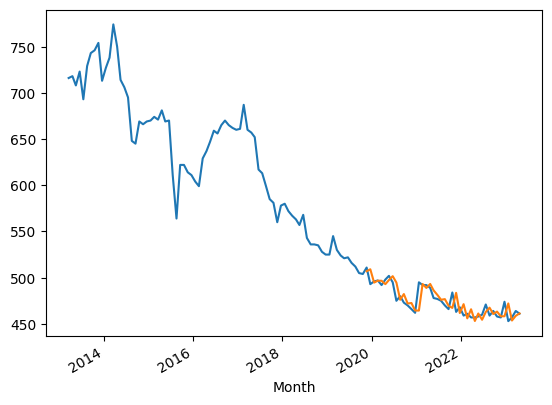

In [ ]:
history_series = pd.Series(history, index=series.index[:len(history)])
predictions_series = pd.Series(predictions, index=test.index)

# shift the index of the history_series and predictions_series
history_series.index = history_series.index + pd.DateOffset(days=len(train))
predictions_series.index = predictions_series.index + pd.DateOffset(days=len(train))

history_series.plot()
predictions_series.plot()
plt.show()

###Confidence interval with best model

In [ ]:
X = series.values
X = X.astype('float32')
size = len(X) - 1
train, test = X[0:size], X[size:]
# fit ARIMA model
model = ARIMA(train, order=(4,1,1))
model_fit = model.fit()

result = model_fit.get_forecast()

print('Expected: %.3f' % result.predicted_mean)
print('Forecast: %.3f' % test[0])
print('Standard Error: %.3f' % result.se_mean)
ci = result.conf_int(0.05)
print('95%% Interval: %.3f to %.3f' % (ci[0,0], ci[0,1]))

Expected: 461.370
Forecast: 461.000
Standard Error: 15.912
95% Interval: 430.183 to 492.558


In [ ]:
# train/test split
X = series.values
X = X.astype('float32')
size = len(X) - 1
train, test = X[0:size], X[size:]
# fit ARIMA model
model = ARIMA(train, order=(5,1,1))
model_fit = model.fit()
result = model_fit.get_forecast()
forecast = result.predicted_mean

intervals = [0.2, 0.1, 0.05, 0.01]
for a in intervals:
	ci = result.conf_int(alpha=a)
	print('%.1f%% Confidence Interval: %.3f between %.3f and %.3f' % ((1-a)*100, forecast, ci[0,0], ci[0,1]))

80.0% Confidence Interval: 460.880 between 440.423 and 481.337
90.0% Confidence Interval: 460.880 between 434.624 and 487.137
95.0% Confidence Interval: 460.880 between 429.594 and 492.167
99.0% Confidence Interval: 460.880 between 419.763 and 501.998


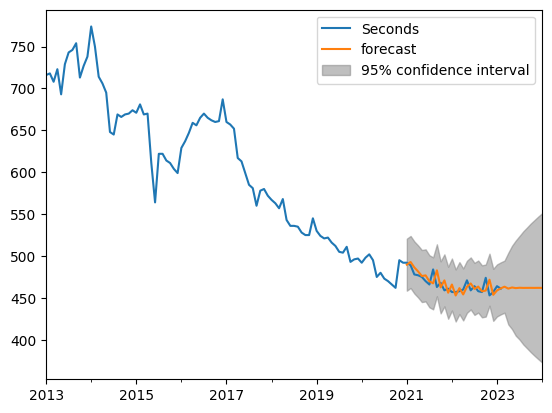

In [ ]:
series.index = pd.date_range(start='2013', end='2023-03', freq='M')
res = ARIMA(series, order=(4,1,1)).fit()
fig, ax = plt.subplots()
ax = series.loc['2013':].plot(ax=ax)
plot_predict(res, '2021', '2024', ax=ax)
plt.show()

###Arima model with box-cox transformation

In [ ]:
def boxcox_inverse(value, lam):
  if lam == 0:
    return math.exp(value)
  return math.exp(math.log(lam * value + 1) / lam)

X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)

train, test = X[0:train_size], X[train_size:]
#walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
  #box cox transform
  transformed, lam = boxcox(history)
  if lam < -5:
    transformed, lam = history, 1

  model = ARIMA(transformed, order=(4,1,1))
  model_fit = model.fit()
  yhat = model_fit.forecast()[0]
  #invert box-cox transform
  yhat = boxcox_inverse(yhat, lam)
  predictions.append(yhat)
  obs = test[i]
  history.append(obs)

rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

RMSE: 10.516


##Chapter 6.



###Linear regressor

In [ ]:
window_size= 10
#train
X_train = []
y_train = []
for i in range(window_size,80):
  X_train.append(series[i-window_size:i])
  y_train.append(series[i])

#test
X_test = []
y_test = []
for i in range(80,122):
  X_test.append(series[i-window_size:i])
  y_test.append(series[i])


model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [ ]:
y_pred = model.predict(X_test)

rmse = sqrt(mean_squared_error(y_test, y_pred))
print('RMSE: %.3f' % rmse)

RMSE: 10.649


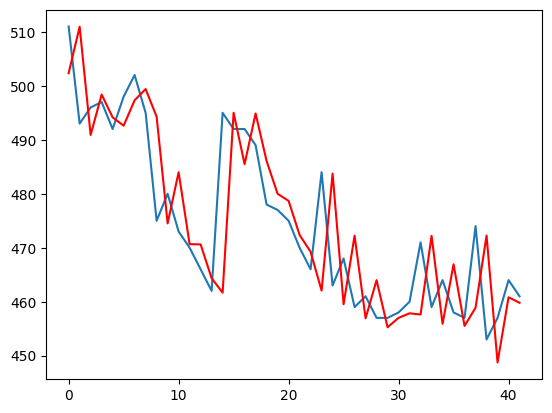

In [ ]:
plt.plot(y_test)
plt.plot(y_pred, color='red')
plt.show()

###SGD Regressor

In [ ]:
model = SGDRegressor(max_iter=1000, tol=1e-3)

scaler = StandardScaler()
X_reshape = scaler.fit_transform(X_train)
model.fit(X_reshape, y_train)

SGDRegressor()

In [ ]:
X_reshape = scaler.transform(X_test)
y_pred = model.predict(X_reshape)

rmse = sqrt(mean_squared_error(y_test, y_pred))
print('RMSE: %.3f' % rmse)

RMSE: 9.657


###Decision tree

In [ ]:
model = RandomForestRegressor(max_depth=2, random_state=0)

model.fit(X_train,y_train)

RandomForestRegressor(max_depth=2, random_state=0)

In [ ]:
y_pred = model.predict(X_test)

rmse = sqrt(mean_squared_error(y_test, y_pred))
print('RMSE: %.3f' % rmse)

RMSE: 54.938


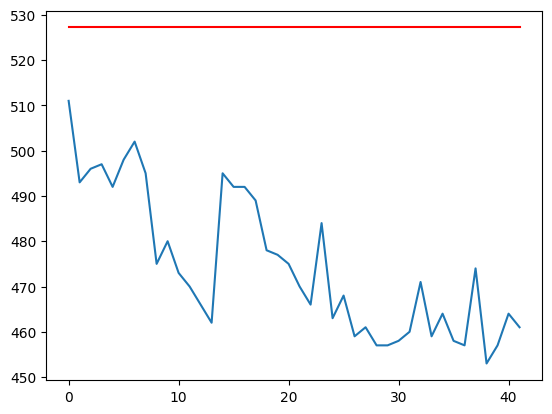

In [ ]:
plt.plot(y_test)
plt.plot(y_pred, color='red')
plt.show()

###Decision tree with walk forward

In [ ]:
X_test = np.array(X_test)
X_train = np.array(X_train)

In [ ]:
def random_forest_forecast(train, testX):
  train = np.asarray(train)
  
  trainX, trainy = train[:, :-1], train[:, -1]

  model = RandomForestRegressor(n_estimators=1000)
  model.fit(trainX, trainy)

  yhat = model.predict([testX])
  return yhat[0]

In [ ]:
y_pred = []

history = [x for x in X_train]

for i in range(len(X_test)):

  testX, testy = X_test[i, :-1], X_test[i, -1]

  yhat = random_forest_forecast(history, testX)

  y_pred.append(yhat)

  history.append(X_test[i])
  

rmse = sqrt(mean_squared_error(y_test, y_pred))
print('RMSE: %.3f' % rmse)

RMSE: 11.523


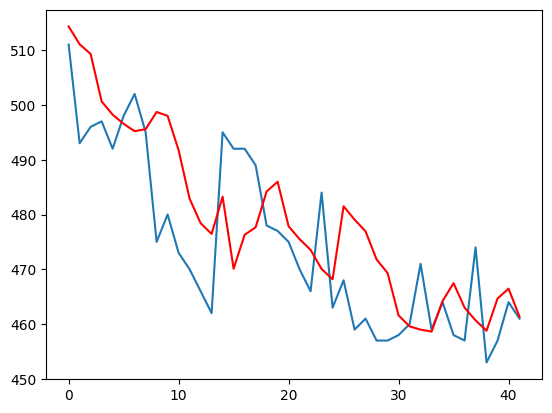

In [ ]:
plt.plot(y_test)
plt.plot(y_pred, color='red')
plt.show()

###Multistep forecast

In [ ]:
window_size= 12
number_of_step = 10
#train
X_train = []
y_train = []
for i in range(window_size,80):
  X_train.append(list(series.values)[i-window_size:i])
  y_train.append(list(series.values)[i:i+number_of_step])
 

#test
X_test = []
y_test = []
for i in range(80,122):
  X_test.append(list(series.values)[i-window_size:i])
  y_test.append(list(series.values)[i:i+number_of_step])
  
X_test = np.array(X_test)
y_test = np.array(y_test)
X_train = np.array(X_train)
y_train = np.array(y_train)

In [ ]:
dirrec = RegressorChain(LinearRegression())
dirrec.fit(X_train, y_train )

RegressorChain(base_estimator=LinearRegression())

In [ ]:
def plot_predict(X_test,y_test,y_pred):
  x_index = list(range(len(X_test)))
  plt.plot(x_index, X_test,label='history')
  y_index = list(range(len(X_test)-1,len(X_test)+len(y_test)))
  plt.plot(y_index, np.concatenate((X_test[-1:],y_test)),label='real')
  plt.plot(y_index, np.concatenate((X_test[-1:],y_pred)),label='forecast')
  plt.legend()
  plt.show()

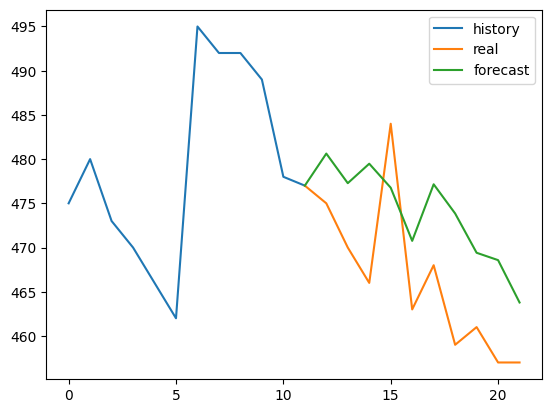

In [ ]:
sample = 20
X_sample = X_test[sample:sample+1,:]
y_sample = y_test[sample]
y_pred = dirrec.predict(X_sample)[0]
plot_predict(X_sample[-1,:],y_sample,y_pred)